## Preprocessing Active Losses

In [1]:
!pip install optuna
# !pip install xgboost
!pip install plotnine
!pip install skimpy
!pip install holidays
!pip install blackcellmagic
!pip install scikit-learn

  Using cached optuna-3.4.0-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.12.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.26.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata (61 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached PyYAML-6.0.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata (2.1 kB)
  Using cached Mako-1.3.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-2.1.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata (3.0 kB)
Using cached optuna-3.4.0-py3-none-any.whl (409 kB)
Using cached alembic-1.12.1-py3-none-any.whl (226 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.8 MB/s eta 0:00:0000:0100:01m
Using cached numpy-1.26.1-cp311-cp311-macosx_10_9_x86_64.whl (20.6 MB)
Using cached PyYAML-6.0.1-cp311-cp311-macosx_10_9_x86_64.whl (187 kB)
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 1.1

In [2]:
import optuna
from optuna.integration.tensorboard import TensorBoardCallback
from optuna.trial import TrialState

# from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, percent_format, currency_format
from datetime import datetime, timedelta, date
from tqdm.notebook import tqdm
from skimpy import clean_columns
from IPython.display import clear_output, display
import holidays

from pickle import dump, load

pd.set_option("display.max.columns", 50)

%load_ext blackcellmagic

### Reading in the Data

> **Achtung**: Ich konvertiere hier die "Bis-Zeitstempel", für die Viertel- und stündlichen Werte zu "Von-Zeitstempel"

- Viertelstündlich: 15 Minuten nach hinten ziehen
- Stündlich: Eine Stunde nach hinten ziehen

In [21]:
!cd ..

In [22]:
!ls


0_Data Preprocessing Base.ipynb 2_ElasticNet.ipynb


In [25]:
active_losses = pd.read_csv("/Users/yanistournier/Desktop/energydatahackdays23/energydatahackdays23/data/Active-Losses-2019-2021.csv")

active_losses.columns = active_losses.iloc[
    0,
]
active_losses = (
    active_losses.drop(active_losses.index[0])
    .assign(
        Zeitstempel=lambda x: (
            pd.to_datetime(x["Zeitstempel"]) - pd.Timedelta("15 minutes")
        ).dt.floor(freq="H"),
        kWh=lambda x: pd.to_numeric(x["kWh"]) / 1000,
    )
    .groupby("Zeitstempel")
    .agg(MWh=("kWh", "sum"))
    .reset_index()
)
active_losses

,Zeitstempel,MWh
0,2019-01-01 00:00:00,139.525004
1,2019-01-01 01:00:00,129.716036
2,2019-01-01 02:00:00,133.398074
3,2019-01-01 03:00:00,135.133852
4,2019-01-01 04:00:00,131.699424
...,...,...
26299,2021-12-31 19:00:00,171.707318
26300,2021-12-31 20:00:00,159.462903
26301,2021-12-31 21:00:00,155.109520
26302,2021-12-31 22:00:00,171.370277


In [27]:
renewables = pd.read_csv(
    "/Users/yanistournier/Desktop/energydatahackdays23/energydatahackdays23/data/eq_renewables_2019-2021.csv", parse_dates=["datetime"]
).pipe(clean_columns)
renewables

,datetime,solar_fore_de_mw,solar_fore_it_mw,wind_fore_de_mw,wind_fore_it_mw
0,2019-01-01 00:00:00,0.0,0.0,21344.8514,4302.6977
1,2019-01-01 01:00:00,0.0,0.0,23052.3310,4596.5916
2,2019-01-01 02:00:00,0.0,0.0,24969.9701,4478.5564
3,2019-01-01 03:00:00,0.0,0.0,27082.9626,4323.3712
4,2019-01-01 04:00:00,0.0,0.0,26890.9717,4231.8283
...,...,...,...,...,...
26299,2021-12-31 19:00:00,0.0,0.0,36997.7200,1108.4000
26300,2021-12-31 20:00:00,0.0,0.0,35666.9300,1077.9700
26301,2021-12-31 21:00:00,0.0,0.0,34383.8800,1048.2800
26302,2021-12-31 22:00:00,0.0,0.0,33075.2500,1078.7800


In [28]:
temperature = pd.read_csv(
    "/Users/yanistournier/Desktop/energydatahackdays23/energydatahackdays23/data/eq_temp_2019-2021.csv", parse_dates=["datetime"]
).assign(datetime=lambda x: x["datetime"] - pd.Timedelta("1 hour"))

temperature

,datetime,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it
0,2019-01-01 00:00:00,4.1067,5.9729,7.4268,4.0281
1,2019-01-01 06:00:00,1.7595,5.5398,6.3425,2.7281
2,2019-01-01 12:00:00,4.8823,8.6471,7.4596,7.7386
3,2019-01-01 18:00:00,3.1899,6.7846,5.2598,3.9186
4,2019-01-02 00:00:00,4.0144,6.4055,4.1154,3.5786
...,...,...,...,...,...
9775,2021-12-31 18:00:00,8.5300,9.9600,10.7900,9.5900
9776,2021-12-31 19:00:00,8.0000,9.4000,10.6300,9.1100
9777,2021-12-31 20:00:00,7.5000,8.8800,10.5100,8.6700
9778,2021-12-31 21:00:00,6.9700,8.5100,10.3200,8.1400


In [29]:
ntc = pd.read_csv("/Users/yanistournier/Desktop/energydatahackdays23/energydatahackdays23/data/NTC_2019_2021.csv", parse_dates=["datetime"])
ntc

,datetime,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH
0,2019-01-01 00:00:00,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
1,2019-01-01 01:00:00,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
2,2019-01-01 02:00:00,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
3,2019-01-01 03:00:00,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
4,2019-01-01 04:00:00,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
...,...,...,...,...,...,...,...,...,...
26299,2021-12-31 19:00:00,1200.0,4000.0,1400.0,4069.0,1200.0,800.0,3200.0,1810.0
26300,2021-12-31 20:00:00,1200.0,4000.0,1400.0,4069.0,1200.0,800.0,3200.0,1810.0
26301,2021-12-31 21:00:00,1200.0,4000.0,1400.0,3953.0,1200.0,800.0,3200.0,1810.0
26302,2021-12-31 22:00:00,1200.0,4000.0,1400.0,3780.0,1200.0,800.0,3200.0,1810.0


In [30]:
df = (
    active_losses
    .merge(
        temperature, how="left", left_on="Zeitstempel", right_on="datetime"
    )
    .drop("datetime", axis=1)
    .ffill()
    .merge(renewables, how="left", left_on="Zeitstempel", right_on="datetime")
    .drop("datetime", axis=1)
    .merge(ntc, how="left", left_on="Zeitstempel", right_on="datetime")
    .drop("datetime", axis=1)
)

df

,Zeitstempel,MWh,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it,solar_fore_de_mw,solar_fore_it_mw,wind_fore_de_mw,wind_fore_it_mw,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH
0,2019-01-01 00:00:00,139.525004,4.1067,5.9729,7.4268,4.0281,0.0,0.0,21344.8514,4302.6977,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
1,2019-01-01 01:00:00,129.716036,4.1067,5.9729,7.4268,4.0281,0.0,0.0,23052.3310,4596.5916,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
2,2019-01-01 02:00:00,133.398074,4.1067,5.9729,7.4268,4.0281,0.0,0.0,24969.9701,4478.5564,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
3,2019-01-01 03:00:00,135.133852,4.1067,5.9729,7.4268,4.0281,0.0,0.0,27082.9626,4323.3712,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
4,2019-01-01 04:00:00,131.699424,4.1067,5.9729,7.4268,4.0281,0.0,0.0,26890.9717,4231.8283,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26309,2021-12-31 19:00:00,171.707318,8.0000,9.4000,10.6300,9.1100,0.0,0.0,36997.7200,1108.4000,1200.0,4000.0,1400.0,4069.0,1200.0,800.0,3200.0,1810.0
26310,2021-12-31 20:00:00,159.462903,7.5000,8.8800,10.5100,8.6700,0.0,0.0,35666.9300,1077.9700,1200.0,4000.0,1400.0,4069.0,1200.0,800.0,3200.0,1810.0
26311,2021-12-31 21:00:00,155.109520,6.9700,8.5100,10.3200,8.1400,0.0,0.0,34383.8800,1048.2800,1200.0,4000.0,1400.0,3953.0,1200.0,800.0,3200.0,1810.0
26312,2021-12-31 22:00:00,171.370277,6.7900,8.2200,10.2300,7.6700,0.0,0.0,33075.2500,1078.7800,1200.0,4000.0,1400.0,3780.0,1200.0,800.0,3200.0,1810.0


### Combining Features and EDA

In [31]:
df.head()

,Zeitstempel,MWh,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it,solar_fore_de_mw,solar_fore_it_mw,wind_fore_de_mw,wind_fore_it_mw,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH
0,2019-01-01 00:00:00,139.525004,4.1067,5.9729,7.4268,4.0281,0.0,0.0,21344.8514,4302.6977,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
1,2019-01-01 01:00:00,129.716036,4.1067,5.9729,7.4268,4.0281,0.0,0.0,23052.3310,4596.5916,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
2,2019-01-01 02:00:00,133.398074,4.1067,5.9729,7.4268,4.0281,0.0,0.0,24969.9701,4478.5564,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
3,2019-01-01 03:00:00,135.133852,4.1067,5.9729,7.4268,4.0281,0.0,0.0,27082.9626,4323.3712,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0
4,2019-01-01 04:00:00,131.699424,4.1067,5.9729,7.4268,4.0281,0.0,0.0,26890.9717,4231.8283,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0


Let's look at missing values first:

In [32]:
df.isna().sum()

Zeitstempel            0
MWh                    0
temperature_fore_ch    0
temperature_fore_fr    0
temperature_fore_de    0
temperature_fore_it    0
solar_fore_de_mw       3
solar_fore_it_mw       3
wind_fore_de_mw        3
wind_fore_it_mw        3
CH_AT                  3
CH_DE                  3
CH_FR                  3
CH_IT                  3
AT_CH                  3
DE_CH                  3
FR_CH                  3
IT_CH                  3
dtype: int64

There aren't many missing values at all, they will just be mean-imputed.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26314 entries, 0 to 26313
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Zeitstempel          26314 non-null  datetime64[ns]
 1   MWh                  26314 non-null  float64       
 2   temperature_fore_ch  26314 non-null  float64       
 3   temperature_fore_fr  26314 non-null  float64       
 4   temperature_fore_de  26314 non-null  float64       
 5   temperature_fore_it  26314 non-null  float64       
 6   solar_fore_de_mw     26311 non-null  float64       
 7   solar_fore_it_mw     26311 non-null  float64       
 8   wind_fore_de_mw      26311 non-null  float64       
 9   wind_fore_it_mw      26311 non-null  float64       
 10  CH_AT                26311 non-null  float64       
 11  CH_DE                26311 non-null  float64       
 12  CH_FR                26311 non-null  float64       
 13  CH_IT                26311 non-

After that let's analyse the available variables a bit more:

/Users/yanistournier/miniconda3/envs/active_loss/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 36 rows containing non-finite values.
/Users/yanistournier/miniconda3/envs/active_loss/lib/python3.11/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


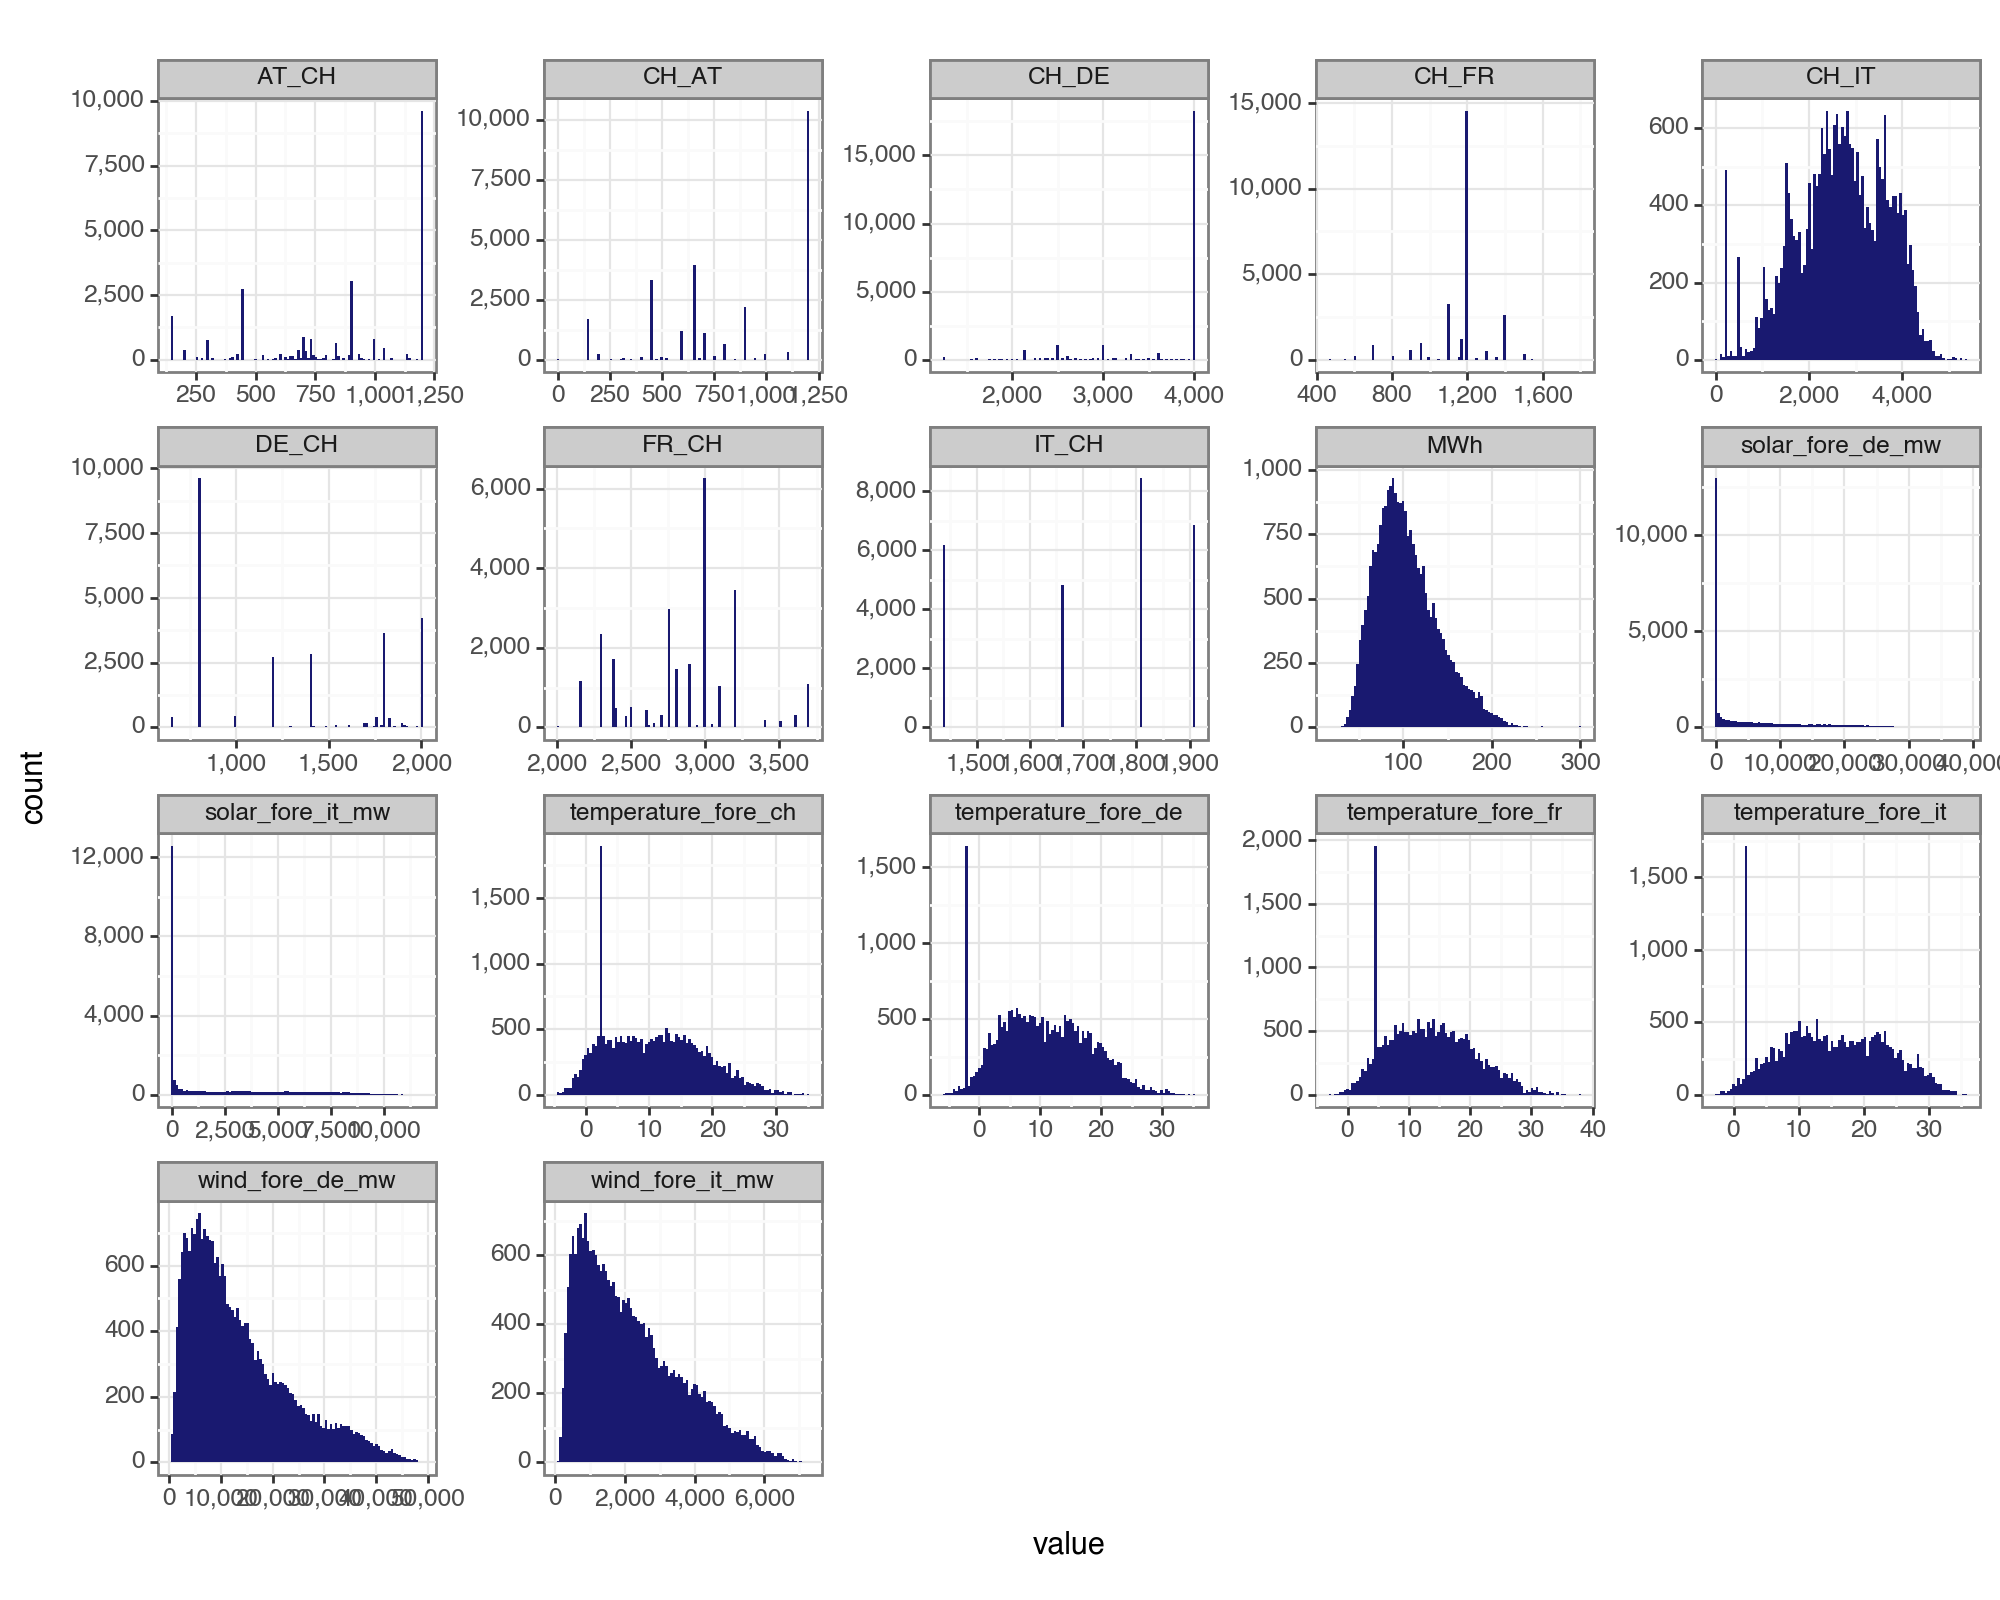

<Figure Size: (1000 x 800)>

In [34]:
(
    ggplot(data=df.select_dtypes(include="number").melt(), mapping=aes(x="value"))
    + geom_histogram(bins=100, fill="midnightblue")
    + facet_wrap("~ variable", scales="free")
    + scale_x_continuous(labels=comma_format())
    + scale_y_continuous(labels=comma_format())
    + theme_bw()
    + theme(figure_size=[10, 8], subplots_adjust={'wspace': 0.5, 'hspace': 0.5})
)

### Additional Feature Generation

- There might be a benefit of encoding cyclical calendar information
- Additionally: Holidays

In [35]:
# Define the country (Switzerland)
country = "CH"

regional_holidays = holidays.CH(
    years=df.Zeitstempel.dt.year.unique().tolist()
)

In [36]:
holiday_df = pd.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
)

holiday_df.head()

,holiday_name,holiday_date
0,Neujahrestag,2019-01-01
1,Ostern,2019-04-21
2,Auffahrt,2019-05-30
3,Pfingsten,2019-06-09
4,Nationalfeiertag,2019-08-01


In [37]:
holiday_df.value_counts("holiday_name")

holiday_name
Auffahrt            3
Nationalfeiertag    3
Neujahrestag        3
Ostern              3
Pfingsten           3
Weihnachten         3
Name: count, dtype: int64

Might be good to encode those as dummies separately, as these days might have different effects. Let's add those days onto the original dataframe:

In [38]:
df = (
    df.assign(
        hour=lambda x: x.Zeitstempel.dt.hour + 1,
        month=lambda x: x.Zeitstempel.dt.month,
        quarter=lambda x: x.Zeitstempel.dt.quarter,
        wday=lambda x: x.Zeitstempel.dt.day_of_week + 1,
        weekend=lambda x: np.where(
            x.Zeitstempel.dt.day_name().isin(["Sunday", "Saturday"]), 1, 0
        ).astype(str),
        work_hour=lambda x: np.where(
            x["hour"].isin([19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5, 6, 7]), 0, 1
        ).astype(str),
        week_hour=lambda x: x.Zeitstempel.dt.dayofweek * 24 + (x.Zeitstempel.dt.hour + 1),
        year=lambda x: x.Zeitstempel.dt.year,
        hour_counter=lambda x: np.arange(0, x.shape[0])
    )
    .assign(day=lambda x: x.Zeitstempel.dt.date)
    .merge(holiday_df, how="left", left_on="day", right_on="holiday_date")
    .drop(["holiday_date", "day"], axis=1)
    .assign(holiday_name = lambda x: np.where(x["holiday_name"].isna(), "none", x["holiday_name"]))
)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26314 entries, 0 to 26313
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Zeitstempel          26314 non-null  datetime64[ns]
 1   MWh                  26314 non-null  float64       
 2   temperature_fore_ch  26314 non-null  float64       
 3   temperature_fore_fr  26314 non-null  float64       
 4   temperature_fore_de  26314 non-null  float64       
 5   temperature_fore_it  26314 non-null  float64       
 6   solar_fore_de_mw     26311 non-null  float64       
 7   solar_fore_it_mw     26311 non-null  float64       
 8   wind_fore_de_mw      26311 non-null  float64       
 9   wind_fore_it_mw      26311 non-null  float64       
 10  CH_AT                26311 non-null  float64       
 11  CH_DE                26311 non-null  float64       
 12  CH_FR                26311 non-null  float64       
 13  CH_IT                26311 non-

In [40]:
df.value_counts("holiday_name")

holiday_name
none                25882
Auffahrt               72
Nationalfeiertag       72
Neujahrestag           72
Ostern                 72
Pfingsten              72
Weihnachten            72
Name: count, dtype: int64

Those are a few additional features that I can use for prediction-making, which surely hold some additional information. Next, let's decide what happens with which feature.

### Feature Engineering

Other:
- `Zeitstempel`: drop, can't feed into net

Numerical:
- everything but `holiday_name`

Categorical
- `holiday_name`: one-hot encode

#### Cyclical Encoding

- avoid issue with exploding feature space when one-hot encoding hundreds of levels in categorical vars
- puts end of cycle closer to beginning (End of Year is not that different from BOY)

In [41]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [42]:
# hour in day
df["hour_sin"] = sin_transformer(24).fit_transform(df["hour"].astype(float))
df["hour_cos"] = cos_transformer(24).fit_transform(df["hour"].astype(float))

# hour in week
df["week_hour_sin"] = sin_transformer(168).fit_transform(df["week_hour"].astype(float))
df["week_hour_cos"] = cos_transformer(168).fit_transform(df["week_hour"].astype(float))

# month
df["month_sin"] = sin_transformer(12).fit_transform(df["month"].astype(float))
df["month_cos"] = cos_transformer(12).fit_transform(df["month"].astype(float))

# quarter
df["quarter_sin"] = sin_transformer(4).fit_transform(df["quarter"].astype(float))
df["quarter_cos"] = cos_transformer(4).fit_transform(df["quarter"].astype(float))

# weekday
df["wday_sin"] = sin_transformer(7).fit_transform(df["wday"].astype(float))
df["wday_cos"] = cos_transformer(7).fit_transform(df["wday"].astype(float))

df = df.drop(["hour", "month", "quarter", "wday", "week_hour"], axis=1)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26314 entries, 0 to 26313
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Zeitstempel          26314 non-null  datetime64[ns]
 1   MWh                  26314 non-null  float64       
 2   temperature_fore_ch  26314 non-null  float64       
 3   temperature_fore_fr  26314 non-null  float64       
 4   temperature_fore_de  26314 non-null  float64       
 5   temperature_fore_it  26314 non-null  float64       
 6   solar_fore_de_mw     26311 non-null  float64       
 7   solar_fore_it_mw     26311 non-null  float64       
 8   wind_fore_de_mw      26311 non-null  float64       
 9   wind_fore_it_mw      26311 non-null  float64       
 10  CH_AT                26311 non-null  float64       
 11  CH_DE                26311 non-null  float64       
 12  CH_FR                26311 non-null  float64       
 13  CH_IT                26311 non-

### Include target lags

... due to autocorrelation (as description said, I'll believe it).

In [44]:
days = df["Zeitstempel"].tolist()

In [45]:
df = df.assign(date = lambda x: x.Zeitstempel.dt.date.astype(str))

In [46]:
prior_cutoff = (days[23] - pd.Timedelta("1 day")).strftime('%Y-%m-%d')
f"{prior_cutoff} 23:00"

'2018-12-31 23:00'

In [47]:
lag_lists = []

for day_idx, day in enumerate(tqdm(days)):
    prior_cutoff = (day - pd.Timedelta("1 day")).strftime('%Y-%m-%d')

    lags = df.query("date <= @prior_cutoff").tail(168)["MWh"].tolist()
    lag_lists.append(lags)

  0%|          | 0/26314 [00:00<?, ?it/s]

In [48]:
lag_df = pd.DataFrame(lag_lists).add_prefix("target_lag_")

In [49]:
df = pd.concat([df.drop("date", axis=1), lag_df], axis=1)

#### `sklearn` Pipeline for Data Preparation

In [50]:
manual_cols = []

pipeline_cols = [col for col in df.drop(["Zeitstempel", "MWh"], axis=1).columns if col not in manual_cols]

num_cols = df.drop(["Zeitstempel", "MWh"], axis=1).filter(pipeline_cols).select_dtypes(include=np.number).columns
cat_cols = df.drop(["Zeitstempel", "MWh"], axis=1).filter(pipeline_cols).select_dtypes(exclude=np.number).columns

In [51]:
pipeline_cols

['temperature_fore_ch',
 'temperature_fore_fr',
 'temperature_fore_de',
 'temperature_fore_it',
 'solar_fore_de_mw',
 'solar_fore_it_mw',
 'wind_fore_de_mw',
 'wind_fore_it_mw',
 'CH_AT',
 'CH_DE',
 'CH_FR',
 'CH_IT',
 'AT_CH',
 'DE_CH',
 'FR_CH',
 'IT_CH',
 'weekend',
 'work_hour',
 'year',
 'hour_counter',
 'holiday_name',
 'hour_sin',
 'hour_cos',
 'week_hour_sin',
 'week_hour_cos',
 'month_sin',
 'month_cos',
 'quarter_sin',
 'quarter_cos',
 'wday_sin',
 'wday_cos',
 'target_lag_0',
 'target_lag_1',
 'target_lag_2',
 'target_lag_3',
 'target_lag_4',
 'target_lag_5',
 'target_lag_6',
 'target_lag_7',
 'target_lag_8',
 'target_lag_9',
 'target_lag_10',
 'target_lag_11',
 'target_lag_12',
 'target_lag_13',
 'target_lag_14',
 'target_lag_15',
 'target_lag_16',
 'target_lag_17',
 'target_lag_18',
 'target_lag_19',
 'target_lag_20',
 'target_lag_21',
 'target_lag_22',
 'target_lag_23',
 'target_lag_24',
 'target_lag_25',
 'target_lag_26',
 'target_lag_27',
 'target_lag_28',
 'target_lag_

In [52]:
num_cols

Index(['temperature_fore_ch', 'temperature_fore_fr', 'temperature_fore_de',
       'temperature_fore_it', 'solar_fore_de_mw', 'solar_fore_it_mw',
       'wind_fore_de_mw', 'wind_fore_it_mw', 'CH_AT', 'CH_DE',
       ...
       'target_lag_158', 'target_lag_159', 'target_lag_160', 'target_lag_161',
       'target_lag_162', 'target_lag_163', 'target_lag_164', 'target_lag_165',
       'target_lag_166', 'target_lag_167'],
      dtype='object', length=196)

In [53]:
cat_cols

Index(['weekend', 'work_hour', 'holiday_name'], dtype='object')

In [54]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

# Making column transformer where all transformers in the pipelines are included
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

### Saving Preprocessing Pipeline and Clean Training Data

Let's first move temperatur and globalstrahlung to the beginning of the dataframe in order to keep consistency after left-joining the dirty data for the test period later:

In [55]:
# Define the two columns to be moved to the beginning
columns_to_move = ["Zeitstempel", "MWh"]

# Create a new DataFrame with the desired column order
df = df[columns_to_move + [col for col in df.columns if col not in columns_to_move]]

df.head()

,Zeitstempel,MWh,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it,solar_fore_de_mw,solar_fore_it_mw,wind_fore_de_mw,wind_fore_it_mw,CH_AT,CH_DE,CH_FR,CH_IT,AT_CH,DE_CH,FR_CH,IT_CH,weekend,work_hour,year,hour_counter,holiday_name,hour_sin,hour_cos,...,target_lag_143,target_lag_144,target_lag_145,target_lag_146,target_lag_147,target_lag_148,target_lag_149,target_lag_150,target_lag_151,target_lag_152,target_lag_153,target_lag_154,target_lag_155,target_lag_156,target_lag_157,target_lag_158,target_lag_159,target_lag_160,target_lag_161,target_lag_162,target_lag_163,target_lag_164,target_lag_165,target_lag_166,target_lag_167
0,2019-01-01 00:00:00,139.525004,4.1067,5.9729,7.4268,4.0281,0.0,0.0,21344.8514,4302.6977,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,0,2019,0,Neujahrestag,0.258819,0.965926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,129.716036,4.1067,5.9729,7.4268,4.0281,0.0,0.0,23052.3310,4596.5916,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,0,2019,1,Neujahrestag,0.500000,0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,133.398074,4.1067,5.9729,7.4268,4.0281,0.0,0.0,24969.9701,4478.5564,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,0,2019,2,Neujahrestag,0.707107,0.707107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,135.133852,4.1067,5.9729,7.4268,4.0281,0.0,0.0,27082.9626,4323.3712,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,0,2019,3,Neujahrestag,0.866025,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,131.699424,4.1067,5.9729,7.4268,4.0281,0.0,0.0,26890.9717,4231.8283,700.0,4000.0,1200.0,2513.0,1200.0,800.0,3000.0,1910.0,0,0,2019,4,Neujahrestag,0.965926,0.258819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saving the sklearn pipeline on the training dataset:

In [56]:
dump(preprocessor, open('sklearn_base_pipeline_unfitted.pickle', 'wb'))

Saving the preprocessed dataframe in order to get back to the timestamps:

In [57]:
df.to_csv("df_base_trainval_preprocessed.csv", index=False)